In [214]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [215]:
import joblib

rd = joblib.load('data/folds.pickle')
rd

[([(array([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19,
           21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38,
           39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56,
           57, 58, 59]),
    array([ 1,  8, 13, 20, 36, 55, 60])),
   (array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
           19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
           37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54,
           55, 57, 58, 60]),
    array([ 5, 17, 21, 50, 56, 59])),
   (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18,
           20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37,
           38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56,
           57, 58, 59, 60]),
    array([11, 12, 19, 28, 49, 54])),
   (array([ 0,  1,  2,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 19,
         

In [216]:
call = pd.read_csv("data/Train_call.txt", sep='\t')
clin = pd.read_csv("data/Train_clinical.txt", sep='\t')
print(call.head())
print(clin.head())

X=call[clin[clin['Subgroup']!='HER2+']['Sample']]
print(X)
X=X.T.reset_index(drop=True)
X
#X.shape

   Chromosome   Start     End  Nclone  Array.129  Array.34  Array.67  \
0           1    2927   43870       3          0         0         0   
1           1   85022  216735       4          0         0         0   
2           1  370546  372295       4          0         0         0   
3           1  471671  786483       5          0         0         0   
4           1  792533  907406      13          0         0         0   

   Array.24  Array.22  Array.36  ...  Array.64  Array.89  Array.30  Array.35  \
0         0         0         0  ...         0         0         1         0   
1         0         0         0  ...         0         0         1         0   
2         0         0         0  ...         0         0         1         0   
3         0         0         0  ...         0         1         1         0   
4         0         0         0  ...         0         1         1         0   

   Array.93  Array.10  Array.123  Array.100  Array.134  Array.130  
0         0       

,0,1,2,3,4,5,6,7,8,9,...,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
64,0,0,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,1,1
65,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
66,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [217]:
y = clin[clin['Subgroup']!='HER2+']['Subgroup'].reset_index(drop=True)
y
#y.shape

0            HR+
1            HR+
2     Triple Neg
3     Triple Neg
4            HR+
         ...    
63           HR+
64    Triple Neg
65           HR+
66           HR+
67           HR+
Name: Subgroup, Length: 68, dtype: object

## Variance Threshold

In [218]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.8) # Variance threshold
sel = selector.fit(X)
sel_index = sel.get_support()
norm_vt = X.iloc[:, sel_index]
print(norm_vt.columns)

Int64Index([ 192, 1068, 1074, 1075, 1076, 1080, 1084, 1085, 1086, 1087, 1088,
            1089, 1090, 1091, 1092, 1604],
           dtype='int64')


## Chi-square test

In [219]:
from numpy import array
import sklearn
#导入sklearn库中的SelectKBest和chi2
from sklearn.feature_selection import SelectKBest ,chi2


X_transform = sklearn.preprocessing.MinMaxScaler().fit_transform(X)
#选择相关性最高的前5个特征
select = SelectKBest(chi2, k=10)
X_chi2 = select.fit_transform(X_transform, y)

filter = select.get_support()
features = array(X.columns.values)

print("Selected best 10:")
print(features[filter])


Selected best 10:
[ 694  695  697  818 1973 2023 2024 2026 2027 2750]


## ANOVA F-value

1678 25.608978855596753
1656 24.15932773109244
1672 22.208512353629402
1679 21.26248942530032
1668 21.151580616618595
1667 21.151580616618595
1677 21.137254901960787
1664 20.796553016110902
1674 20.63277952402335
694 20.383816875166357
[1678, 1656, 1672, 1679, 1668, 1667, 1677, 1664, 1674, 694]


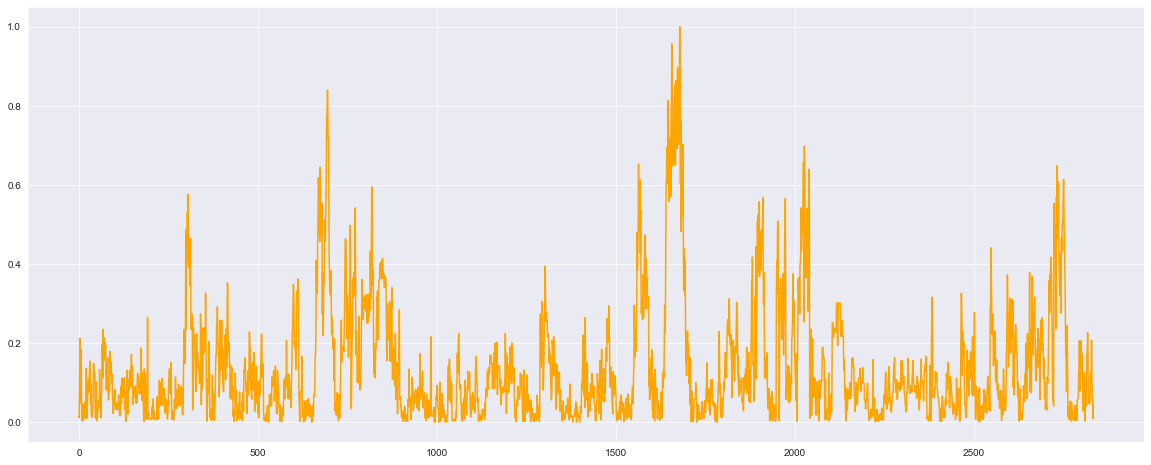

In [220]:
from sklearn.feature_selection import SelectPercentile, f_classif

threshold = 10 # the number of most relevant features
high_score_features = []
F,p = f_classif(X, y)
for score, f_name in sorted(zip(F, X.columns), reverse=True)[:threshold]:
      print(f_name, score)
      high_score_features.append(f_name)

print(high_score_features)


plt.figure(figsize = (20,8))
X_indices = np.arange(X.shape[-1])
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.plot(X_indices - .45, scores,
        label=r'Univariate score ($-Log(p_{value})$)', color='orange')

## Mutual information

In [221]:
from sklearn.feature_selection import mutual_info_classif
threshold = 10  # the number of most relevant features
high_score_features = []
feature_scores = mutual_info_classif(X, y, random_state=0)
for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
        print(f_name, score)
        high_score_features.append(f_name)
norm_mic = X[high_score_features]
print(norm_mic.columns)

1679 0.27488031926298917
2748 0.27055519177609666
1660 0.26119317051107527
1656 0.25873844859040895
2751 0.2415170730320959
733 0.23085895300933856
1671 0.22776224126255817
1582 0.22388939993524604
913 0.21095992593083124
1646 0.20891817683025837
Int64Index([1679, 2748, 1660, 1656, 2751, 733, 1671, 1582, 913, 1646], dtype='int64')


## Embedded Methods

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
model_lr = LogisticRegression(random_state=0, C=0.01)
model_rf = RandomForestClassifier(n_estimators=500, random_state=0, max_depth = 3)
model_lr.fit(X, y)
#model_rf.fit(df_wine_norm_features, df_wine_target)
sel_sfm = SelectFromModel(model_lr, prefit=True, max_features=10)
sel_sfm_index = sel_sfm.get_support()
df_wine_norm_sfm = X.iloc[:, sel_sfm_index]
print(df_wine_norm_sfm.columns)

Int64Index([192, 1060, 1061, 1243, 2017, 2021, 2023, 2024, 2026, 2027], dtype='int64')


## Wrapper Methods

In [223]:

from sklearn.feature_selection import RFE
threshold = 10 # 最相关特征的数量
model_rf = RandomForestClassifier(n_estimators=500,random_state=0, max_depth = 3)
#model_lr = LogisticRegression(random_state=0, C=0.01)
selector = RFE(model_rf , n_features_to_select=threshold, step=1)
selector = selector.fit(X, y)
selector_ind = selector.get_support()
norm_rfe = X.iloc[:, selector_ind]
print(norm_rfe.columns)

Int64Index([386, 694, 743, 1656, 1672, 1678, 2547, 2732, 2735, 2751], dtype='int64')
